In [1]:
from IPython.display import HTML

HTML('''
    <script>
        code_show=true; 
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
                $('button#code-toggle').text('Show Code');
            } else {
                $('div.input').show();
                $('button#code-toggle').text('Hide Code');
            }
            code_show = !code_show
        }
    </script>

    <button id="code-toggle" onclick="javascript:code_toggle()">
        Hide Code
    </button>
''')

# Challenge: Make Your Own Multivariate Regression Model

Using the UCR crime dataset, build a regression model to predict property crimes. You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination. The goal here is prediction vs. understanding mechanisms, so focus on creating a model that explains a lot of variance.


In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
%matplotlib inline

pd.options.display.float_format = '{:,.0f}'.format

crime_df = pd.read_excel('./crimes/NY_crimes.xls', header=4)
crime_df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0,nan,0,0,0,12,2,10,0,0
1,Addison Town and Village,"2,577",3,0,nan,0,0,3,24,3,20,1,0
2,Akron Village,"2,846",3,0,nan,0,0,3,16,1,15,0,0
3,Albany,"97,956",791,8,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0,nan,3,4,16,223,53,165,5,nan


In [3]:
def clean_data(df, state):
    df['Violent crime per capita'] = df['Violent\ncrime'] / df['Population']
    df['Log Violent crime'] = np.log(1 + df['Violent\ncrime'])
    df['Log Larceny'] = np.log(1 + df['Larceny-\ntheft'])
    df['Log Population'] = np.log(df['Population'])
    df['Population Sq.'] = df['Population'] ** 2
    df['Robbery Categ'] = np.where(df['Robbery'] > 0, 1, 0)
    df['Murder Categ'] = np.where(df['Murder and\nnonnegligent\nmanslaughter'] > 0, 1, 0)
    df['Assault Categ'] = np.where(df['Aggravated\nassault'] > 0, 1, 0)
    df['Rape Categ'] = np.where(df['Rape\n(legacy\ndefinition)2'] > 0, 1, 0)

    arson_text = 'Arson3' if state == 'NY' else 'Arson'
    
    df = df.drop(['Rape\n(revised\ndefinition)1'], axis=1)
    df = df[pd.notnull(df['Population'])]
    df.rename(columns = {
        'Violent\ncrime': 'Violent crime', 
        'Murder and\nnonnegligent\nmanslaughter': 'Murder', 
        'Rape\n(legacy\ndefinition)2':'Rape', 
        'Aggravated\nassault': 'Assault', 
        'Property\ncrime': 'Property crime',
        'Motor\nvehicle\ntheft': 'Vehicle theft',
        'Larceny-\ntheft': 'Larceny',
        arson_text: 'Arson'
    }, inplace = True)
    
    pop_cutoff_1 = df['Population'].quantile(0.25)
    pop_cutoff_2 = df['Population'].quantile(0.75)
    
    def get_pop_tier(row):
        if row['Population'] > pop_cutoff_2:
            return 3
        elif row['Population'] > pop_cutoff_1:
            return 2
        else:
            return 1
    df['Population tier'] = [get_pop_tier(row) for i, row in df.iterrows()]

#     df['Violent crimes add up'] = df['Violent crime'] == df['Murder'] + df['Rape'] + df['Robbery'] +df['Assault']
#     df['More crimes than people'] = df['Violent crime'] > df['Population']

#     print('{} rows where violent crimes did not add up'.format(len(df) - np.sum(df['Violent crimes add up'])))
#     print('{} rows where more crimes than people'.format(np.sum(df['More crimes than people'])))

#     df = df.drop(['Violent crimes add up', 'More crimes than people'], axis=1)
    
    return df

crime_df = clean_data(crime_df, 'NY')
crime_df.head()

,City,Population,Violent crime,Murder,Rape,Robbery,Assault,Property crime,Burglary,Larceny,...,Violent crime per capita,Log Violent crime,Log Larceny,Log Population,Population Sq.,Robbery Categ,Murder Categ,Assault Categ,Rape Categ,Population tier
0,Adams Village,"1,861",0,0,0,0,0,12,2,10,...,0,0,2,8,"3,463,321",0,0,0,0,1
1,Addison Town and Village,"2,577",3,0,0,0,3,24,3,20,...,0,1,3,8,"6,640,929",0,0,1,0,1
2,Akron Village,"2,846",3,0,0,0,3,16,1,15,...,0,1,3,8,"8,099,716",0,0,1,0,1
3,Albany,"97,956",791,8,30,227,526,"4,090",705,"3,243",...,0,7,8,11,"9,595,377,936",1,1,1,1,3
4,Albion Village,"6,388",23,0,3,4,16,223,53,165,...,0,3,5,9,"40,806,544",1,0,1,1,2


In [1]:
cities_under_outlier_cutoff = crime_df[crime_df['Population'] < 100000]

def display_relevant_plots(df):
    plt.figure(figsize=(20,20))

    plt.subplot(6, 2, 1)
    plt.scatter(df['Population'], df['Property crime'])
    plt.xlabel('Population')
    plt.ylabel('Property Crimes')
    plt.title('Population vs. Property crime')

    plt.subplot(6, 2, 2)
    plt.scatter(df['Violent crime'], df['Property crime'])
    plt.xlabel('Violent crime')
    plt.ylabel('Property crime')
    plt.title('Violent crime vs. Property crime')
    
    plt.subplot(6, 2, 3)
    plt.scatter(df['Property crime'], df['Murder'], alpha=0.3)
    plt.scatter(df['Property crime'], df['Rape'], alpha=0.3)
    plt.xlabel('Property crime')
    plt.ylabel('Murder / Rape')
    plt.title('Property crime vs. Murder / Rape')
    plt.legend(['Murder', 'Rape'])

    plt.subplot(6, 2, 4)
    plt.scatter(df['Property crime'], df['Robbery'], alpha=0.3)
    plt.scatter(df['Property crime'], df['Assault'], alpha=0.3)
    plt.xlabel('Property crime')
    plt.ylabel('Robbery / Assault')
    plt.title('Property crime vs. Robbery / Assault')
    plt.legend(['Robbery', 'Assault'])
    
    plt.subplot(6, 2, 5)
    plt.scatter(df['Larceny'], df['Property crime'], alpha=0.3)
    plt.ylabel('Property crime')
    plt.xlabel('Larceny')
    plt.title('Larceny vs. Propert Crimes')
    
    plt.subplot(6, 2, 6)
    plt.scatter(df['Property crime'], df['Vehicle theft'], alpha=0.3)
    plt.scatter(df['Property crime'], df['Burglary'], alpha=0.3)
    plt.xlabel('Property crime')
    plt.ylabel('Vehicle theft / Burglary')
    plt.title('Property crime vs. Vehicle theft / Burglary')
    plt.legend(['Vehicle theft', 'Burglary'])
    
    plt.subplot(6, 2, 7)
    plt.hist(df['Log Population'])
    plt.xlabel('Log Population')
    plt.title('Distribution of Logged Population')
    
    plt.subplot(6, 2, 8)
    plt.hist(df['Violent crime'] / df['Population'])
    plt.xlabel('Population')
    plt.title('Violent crime per capita')
    
    plt.subplot(6, 2, 9)
    plt.hist(df['Log Larceny'])
    plt.title('Distribution of Log Larceny')
    
    plt.subplot(6, 2, 10)
    plt.scatter(df['Violent crime'], df['Property crime'])
    plt.xlabel('Violent crime')
    plt.ylabel('Property crime')
    plt.title('Violent crime vs Property crime')

    plt.subplot(6, 2, 11)
    pop_cutoff_1 = crime_df['Population'].quantile(0.25)
    pop_cutoff_2 = crime_df['Population'].quantile(0.75)
    plt.axhline(y=pop_cutoff_1, color='r', linestyle='-')
    plt.axhline(y=pop_cutoff_2, color='b', linestyle='-')
    plt.bar(df['City'], height=df['Population'])
    
    plt.show()
    
    plt.subplot(6, 2, 12)
#     plt.hist(df[df['Larceny'] < 1000]['Larceny'])
#     plt.title('Distribution of Larceny')
    plt.hist(df['Property crime'])
    plt.xlabel('Property crime')
    plt.title('Distribution of Property crime')

display_relevant_plots(cities_under_outlier_cutoff)

NameError: name 'crime_df' is not defined

Next, I will determine where my outliers are.

Lowest Crime Outlier: 53.0
Lowest Murder Outlier: 1.0
Lowest Rape Outlier: 6.0
Lowest Robbery Outlier: 13.0
Lowest Assault Outlier: 34.0
Lowest Population Outlier: 43214.0
Lowest Log Population Outlier: 15.943280966956314


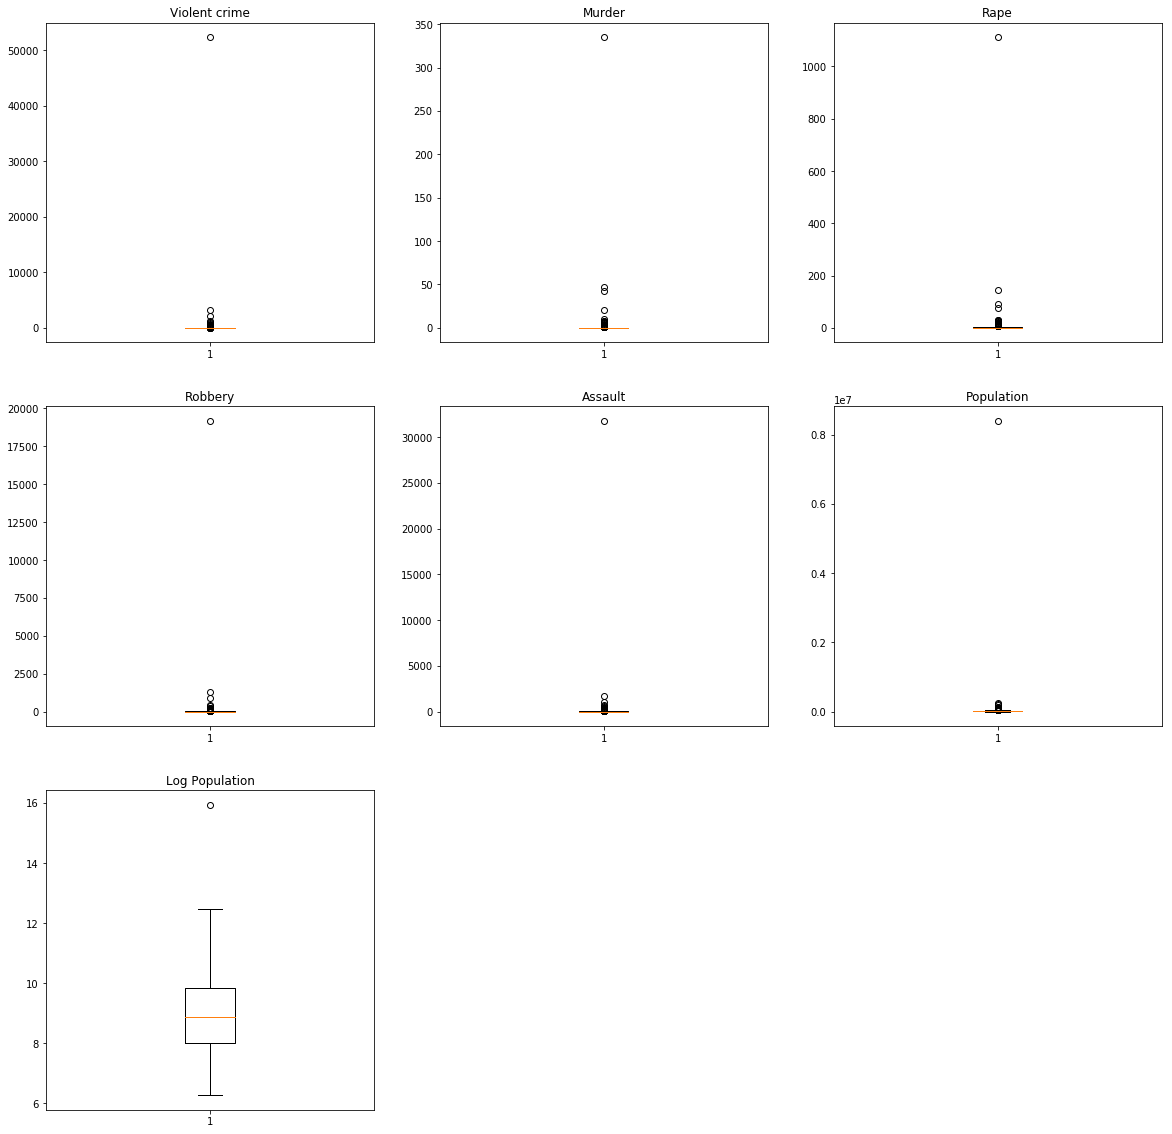

In [5]:
lowest_crime_outlier = 0
lowest_murder_outlier = 0
lowest_rape_outlier = 0
lowest_robbery_outlier = 0
lowest_assault_outlier = 0
lowest_pop_outlier = 0
lowest_pop_sq_outlier = 0

def display_boxplots(df, get_outliers):
    plt.figure(figsize=(20,20))

    plt.subplot(3, 3, 1)
    plt.title('Violent crime')
    result = plt.boxplot(df['Violent crime'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_crime_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Crime Outlier: ' + str(lowest_crime_outlier))

    plt.subplot(3, 3, 2)
    plt.title('Murder')
    result = plt.boxplot(df['Murder'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_murder_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Murder Outlier: ' + str(lowest_murder_outlier))

    plt.subplot(3, 3, 3)
    plt.title('Rape')
    result = plt.boxplot(df['Rape'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_rape_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Rape Outlier: ' + str(lowest_rape_outlier))

    plt.subplot(3, 3, 4)
    plt.title('Robbery')
    result = plt.boxplot(df['Robbery'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_robbery_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Robbery Outlier: ' + str(lowest_robbery_outlier))

    plt.subplot(3, 3, 5)
    plt.title('Assault')
    result = plt.boxplot(df['Assault'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_assault_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Assault Outlier: ' + str(lowest_assault_outlier))

    plt.subplot(3, 3, 6)
    plt.title('Population')
    result = plt.boxplot(df['Population'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_pop_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Population Outlier: ' + str(lowest_pop_outlier))

    plt.subplot(3, 3, 7)
    plt.title('Log Population')
    result = plt.boxplot(df['Log Population'], showcaps=True)
    if get_outliers & len(result["fliers"]):
        lowest_log_pop_outlier = result["fliers"][0].get_data()[1].min()
        print('Lowest Log Population Outlier: ' + str(lowest_log_pop_outlier))
    
    return {
        "crime": lowest_crime_outlier,
        "murder": lowest_murder_outlier,
        "rape": lowest_rape_outlier,
        "robbery": lowest_robbery_outlier,
        "assault": lowest_assault_outlier,
        "pop": lowest_pop_outlier,
        "log_pop": lowest_log_pop_outlier
    } if get_outliers else None

outliers = display_boxplots(crime_df, True)

Now, I will remove these outliers from my dataset and re-examine the data.

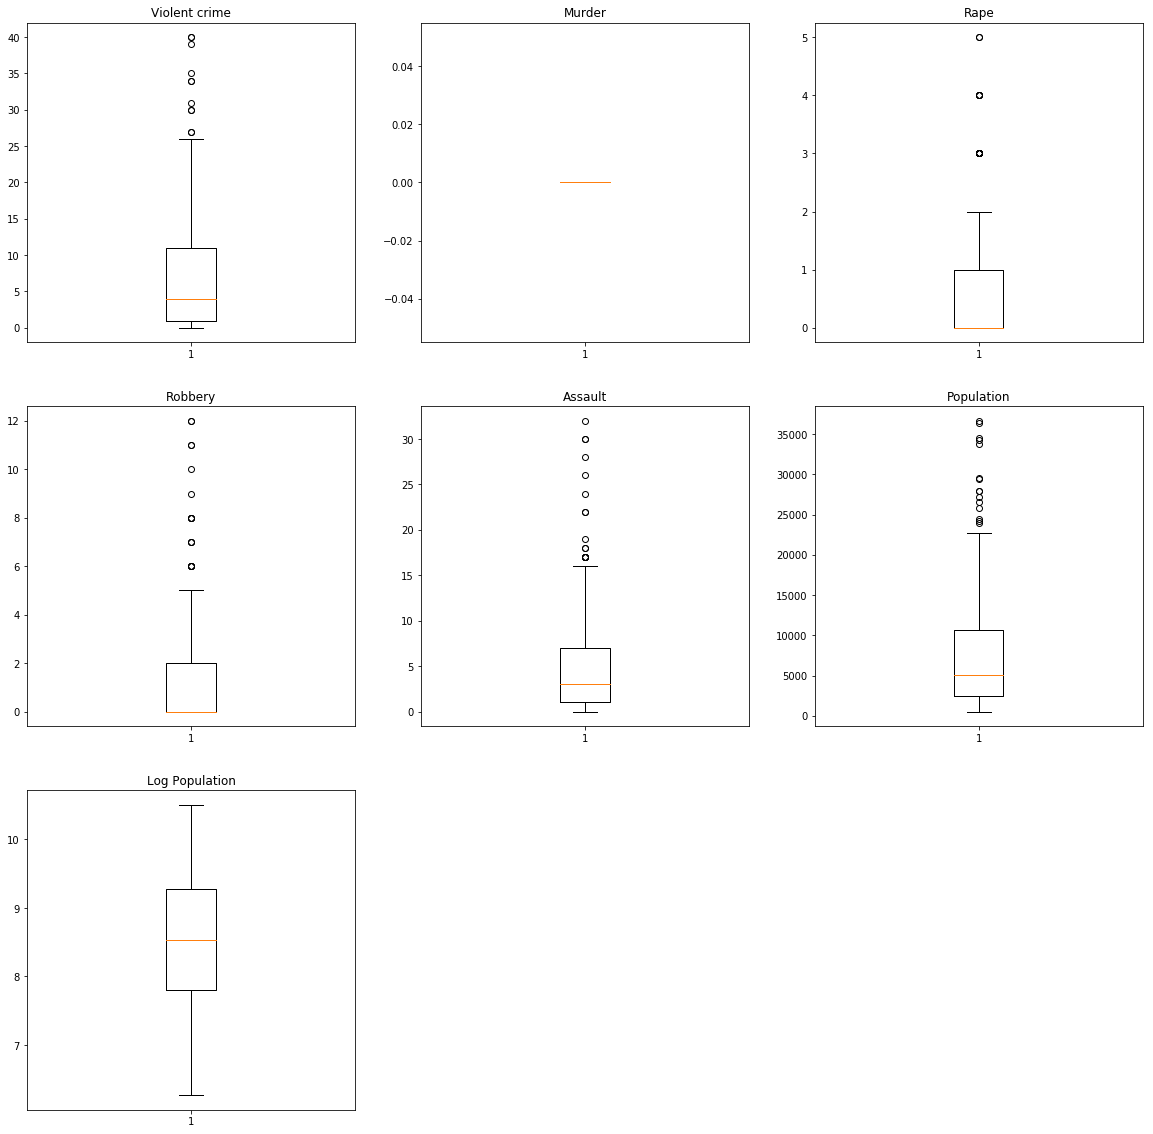

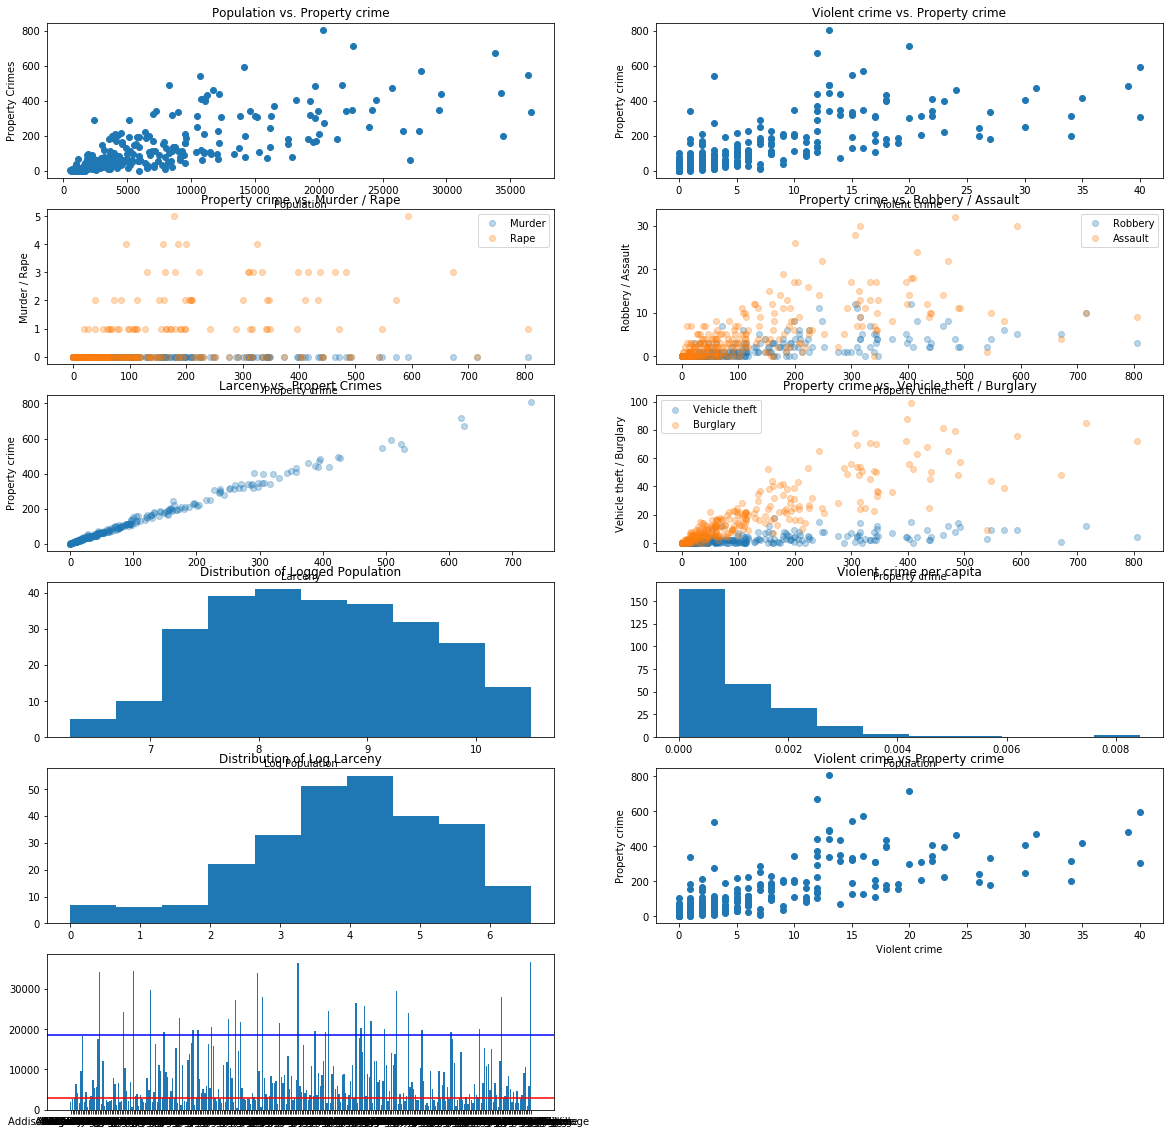

In [6]:
new_df_without_outliers = crime_df[(crime_df['Population'] < outliers['pop']) & (crime_df['Violent crime'] < outliers['crime']) & (crime_df['Murder'] < outliers['murder']) & (crime_df['Rape'] < outliers['rape']) & (crime_df['Robbery'] < outliers['robbery']) & (crime_df['Assault'] < outliers['assault'])]
display_boxplots(new_df_without_outliers, False)

display_relevant_plots(new_df_without_outliers)

## Model

In [7]:
crime_df.head()

,City,Population,Violent crime,Murder,Rape,Robbery,Assault,Property crime,Burglary,Larceny,...,Violent crime per capita,Log Violent crime,Log Larceny,Log Population,Population Sq.,Robbery Categ,Murder Categ,Assault Categ,Rape Categ,Population tier
0,Adams Village,"1,861",0,0,0,0,0,12,2,10,...,0,0,2,8,"3,463,321",0,0,0,0,1
1,Addison Town and Village,"2,577",3,0,0,0,3,24,3,20,...,0,1,3,8,"6,640,929",0,0,1,0,1
2,Akron Village,"2,846",3,0,0,0,3,16,1,15,...,0,1,3,8,"8,099,716",0,0,1,0,1
3,Albany,"97,956",791,8,30,227,526,"4,090",705,"3,243",...,0,7,8,11,"9,595,377,936",1,1,1,1,3
4,Albion Village,"6,388",23,0,3,4,16,223,53,165,...,0,3,5,9,"40,806,544",1,0,1,1,2


In [8]:
crime_df = new_df_without_outliers

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crime_df['Property crime'].values.reshape(-1, 1)
X = crime_df[['Log Population', 'Robbery Categ', 'Murder Categ']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
adjusted_r_squared = 1 - (1-regr.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print(regr.score(X, Y), adjusted_r_squared)


Coefficients: 
 [[83.8635924  85.26656705  0.        ]]

Intercept: 
 [-627.69504209]

R-squared:
0.5460381280970343 0.5409564653518519


## Feature Engineering and Selection Process

Adding a few more features for the regresion model may help make it more accurately predict the outcome (i.e. number of violent crimes).

I will suppose that the number of violent crimes in a city will also help predict how many property crimes there are.

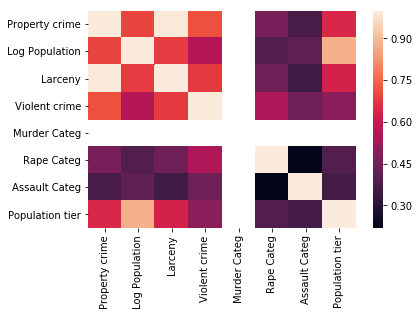

In [9]:
crime_df = crime_df[pd.notnull(crime_df['Property crime'])]

features = ['Property crime', 'Log Population', 'Larceny', 'Violent crime', 'Population tier']
sns.heatmap(crime_df[features].corr())

In [10]:
regr = linear_model.LinearRegression()

# TODO 1: Get rid of property crime outliers
# TODO 2: Take log of property crime and set as output
# we want outcome to be normally distributed if possible
# May improve R-squared value

# TODO 3: Avoid Larceny as predictor ('cheating')

Y = crime_df['Property crime'].values.reshape(-1, 1)
X = crime_df[['Log Population', 'Violent crime', 'Larceny']]
regr.fit(X, Y)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[3.06503576 1.24437857 1.07010261]]

Intercept: 
 [-21.0010964]

R-squared:
0.9951239312977443


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X, Y, cv=3)

array([0.99331453, 0.99606362, 0.99332056])

In [12]:
crime_df['PropertyCrime'] = crime_df['Property crime']
crime_df['LogPopulation'] = crime_df['Log Population']
crime_df['ViolentCrime'] = crime_df['Violent crime']

# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'PropertyCrime ~ LogPopulation + ViolentCrime +Larceny'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=crime_df).fit()
print('Params:')
print(lm.params)

# Todo #3: should not be getting just whole numbers as p-values
# you coudl also test manually by doing t test on data of different categories (i.e. murder 0 vs 1)

print('\nP-Values:')
print(lm.pvalues)

print('\nR-squared:')
print(lm.rsquared, lm.rsquared_adj)

Params:
Intercept       -21
LogPopulation     3
ViolentCrime      1
Larceny           1
dtype: float64

P-Values:
Intercept       0
LogPopulation   0
ViolentCrime    0
Larceny         0
dtype: float64

R-squared:
0.9951239312977443 0.995069348439137


In [ ]:
# Todo #4 Include residual plot